# Medecins

Peut-on établir un lien entre la densité de médecins par spécialité  et par territoire et la pratique du dépassement d'honoraires ? Est-ce  dans les territoires où la densité est la plus forte que les médecins  pratiquent le moins les dépassement d'honoraires ? Est ce que la densité de certains médecins / praticiens est corrélé à la densité de population pour certaines classes d'ages (bebe/pediatre, personnes agées / infirmiers etc...) ?

C'est un sujet assez ouvert pris du Hackathon "données de santé" de Etalab. Il y a un github qui contient une partie des données dont vous aurez besoin. Vous pouvez compléter ça avec de l'INSEE et des données sur la démographie des médecins.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib notebook

# Corrélation entre offre médicale et dépassements d'honoraires

Données issues de l'insee pour la population française par région, et de Etalab pour le nombre de médecin par région.

### Nombre de médecins par région

#### Première exploration

In [2]:
df = pd.read_csv("~/Hors_icloud/Data/rpps_tab3.csv", encoding="utf-8")

In [3]:
df.head(5)

,mode_exercice,zone_inscription,annee,specialite,effectifs
0,Ensemble des modes d'exercice,FRANCE ENTIERE,2014,Ensemble des spécialités d'exercice,219834
1,Ensemble des modes d'exercice,FRANCE ENTIERE,2014,Spécialistes,117694
2,Ensemble des modes d'exercice,FRANCE ENTIERE,2014,Anatomie et cytologie pathologiques,1566
3,Ensemble des modes d'exercice,FRANCE ENTIERE,2014,Anesthésie-réanimation,10949
4,Ensemble des modes d'exercice,FRANCE ENTIERE,2014,Biologie médicale,2662


#### Selection uniquement de l'ensemble des modes d'exercice

In [4]:
df.mode_exercice.unique()

array(["Ensemble des modes d'exercice", 'Libéraux exclusifs', 'Mixtes',
       'Salariés Hospitaliers', 'Autres Salariés'], dtype=object)

In [5]:
df = df[df.mode_exercice == "Ensemble des modes d'exercice"]
df.mode_exercice.unique()

array(["Ensemble des modes d'exercice"], dtype=object)

#### Sélection uniquement de l'année 2014

In [6]:
df.annee.unique()

array([2014, 2013])

In [7]:
df = df[df.annee==2014]
df.annee.unique()

array([2014])

#### Selection par région

In [8]:
# df.zone_inscription.unique()

In [9]:
# on va prendre uniquement les informations par région, c'est à dire les lignes pour 
# lesquelles la zone d'inscription commence par une lettre maj puis une lettre min

df = df[df.zone_inscription.str.match("^[A-Z][a-z]")]

In [10]:
df.zone_inscription.unique()

array(['Alsace', 'Aquitaine', 'Auvergne', 'Basse-Normandie', 'Bourgogne',
       'Bretagne', 'Centre', 'Champagne-Ardenne', 'Corse', 'Franche-Comté',
       'Guadeloupe', 'Guyane', 'Haute-Normandie', 'Ile-de-France',
       'La Réunion', 'Languedoc-Roussillon', 'Limousin', 'Lorraine',
       'Martinique', 'Mayotte', 'Midi-Pyrénées', 'Nord-Pas-de-Calais',
       'Pays de la Loire', 'Picardie', 'Poitou-Charentes',
       'Provence-Alpes-Côte d\x92Azur', 'Rhône-Alpes'], dtype=object)

#### Selection par spécialité

In [11]:
def clean_serie(serie):
    serie = serie.str.title()
    serie = serie.str.strip()
    serie = serie.str.replace("\u0092","")
    serie = serie.str.replace("ô","o")
    serie = serie.str.replace("’","")
    serie = serie.str.replace(" - ","-")
    serie = serie.str.replace("  ","-")
    serie = serie.str.replace(" ","-")
    serie = serie.str.replace("Î","I")
    serie = serie.str.replace('\xa0','')

    return serie

df.zone_inscription = clean_serie(df.zone_inscription)

In [12]:
# on voit que généralistes = médecine générale
# question, est ce que Ensemble des spécialités d'exercice et spécialistes recoupent la même chose?
df_test = df[~ df.specialite.isin(["Généralistes","Médecine générale"]) ]
# Réponse: il semble que oui. Je vais prendre uniquement Spécialistes qui prend la somme de tous les autres

# ON CREE UN DATAFRAME SIMPLE
df_simple = df[df.specialite.isin(["Généralistes","Spécialistes"])]

# ON CREE UN DATAFRAME DETAIL (sans les cumuls:"Généralistes","Spécialistes" )
df_detail = df[~ df.specialite.isin([ "Ensemble des spécialités d'exercice","Généralistes","Spécialistes"])]
# print(df_detail[["specialite","effectifs"]])

### Bilan

On a deux dataframes, df_simple, df_detail, pour l'année 2014 qui ne contiennent plus de redondances

In [13]:
groupby_region = df_simple.groupby("zone_inscription").effectifs.sum()
df_medecin = pd.DataFrame(groupby_region)
df_medecin.columns = ["Médecins"]
# print(df_medecin)

<IPython.core.display.Javascript object>


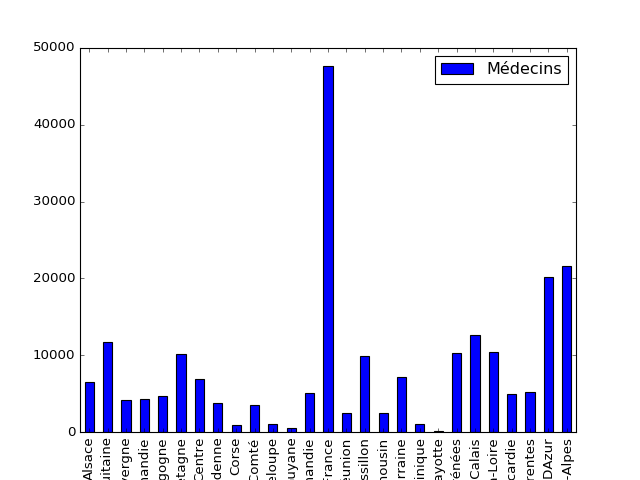

In [14]:
df_medecin.plot.bar()

### Nombre d'habitant par région

On s'appuiera sur les données de l'insee

In [15]:
df_pop = pd.read_csv("~/Hors_icloud/Data/CLEAN_pop.csv", delimiter=";", encoding="utf-8")
print(df_pop.head(5))
print(df_pop.shape)

            REGION 0 à 19 ans 20 à 39 ans 40 à 59 ans 60 à 74 ans  \
0           Alsace    448 447     464 222     528 370     281 361   
1        Aquitaine    755 472     757 009     920 716     577 310   
2         Auvergne    297 490     290 009     374 031     246 010   
3  Basse-Normandie    349 147     315 085     396 745     255 831   
4        Bourgogne    370 905     346 597     441 850     295 924   

  75 ans et plus      Total  
0        159 325  1 881 725  
1        360 429  3 370 936  
2        156 485  1 364 025  
3        162 744  1 479 552  
4        186 582  1 641 858  
(30, 7)


### Merge de population par région et médecins par région

#### Nettoyage

In [16]:

# on met les régions en lower case et on enlève les accents


df_pop.REGION = clean_serie(df_pop.REGION)


# print(long_total_pop)
# print(groupby_region)

In [17]:
long_pop = pd.melt(df_pop,id_vars=["REGION"])

print(long_pop.shape)
# on a s'intéresser pour l'instant uniquement à la population totale par région, on verra ensuite si cela a un 
# intérêt de voir par sexe et par tranche d'âge
long_total_pop = long_pop[long_pop.variable=="Total"][["REGION","value"]]
long_total_pop.columns = ["REGION","Population"]

long_total_pop.Population = long_total_pop.Population.str.replace('\xa0','')

# print(long_total_pop)

(180, 3)


In [18]:
df_merged = pd.merge(long_total_pop, df_medecin.astype(int),how="outer",left_on="REGION",right_index=True)
# print(df_merged)

In [19]:
df_density = df_merged.set_index("REGION")
df_density.dropna(inplace=True)
df_density.head()

,Population,Médecins
REGION,,
Alsace,1881725,6573.0
Aquitaine,3370936,11677.0
Auvergne,1364025,4176.0
Basse-Normandie,1479552,4340.0
Bourgogne,1641858,4740.0


In [20]:
df_density.Population = df_density.Population.astype(int)
df_density["Ratio(‰)"] = df_density.apply(lambda x: x.Médecins/x.Population*1000, axis=1)
# print(df_density)

#### Catégorisation en trois type de densité: faible, moyenne, forte

In [137]:
categories = pd.qcut(df_density["Ratio(‰)"],5,labels=["--","-","moy","+","++"])
df_density["Densité"] = categories
print(df_density.head(5))

                 Population  Médecins  Ratio(‰) Densité
REGION                                                 
Alsace              1881725    6573.0  3.493072      ++
Aquitaine           3370936   11677.0  3.464023      ++
Auvergne            1364025    4176.0  3.061527       +
Basse-Normandie     1479552    4340.0  2.933320     moy
Bourgogne           1641858    4740.0  2.886973       -


## Dépassements d'honoraires

On va déterminer la répartition des dépassements d'honoraires en % du nombre total de prestations, puis en montant brut, par région.

D'abord uniquement sur mois de janvier 2015.

Si l'on veut trouver l'encoding du fichier: file -I \nom fichier\:

R201501.CSV: text/plain; charset=iso-8859-1

In [22]:
colonnes = ["dep_mon","cpam","rem_mon","REM_TAU","rec_mon"]
df_remb = pd.DataFrame(columns=colonnes)
for i in range(1,4):

    if i<10:
        i = "0"+str(i)
    else:
        i = str(i)
    path = "~/Hors_icloud/Data/R2015_sans_lib/R2015" + i + "_sanslib.CSV"
    df_remb_mois = pd.read_csv(path,sep=';',usecols=colonnes)
    
    df_remb_mois.dep_mon = df_remb_mois.dep_mon.str.replace(".","").str.replace(",",".").astype(float)
    df_remb_mois.rec_mon = df_remb_mois.rec_mon.str.replace(".","").str.replace(",",".").astype(float)
    df_remb_mois.rem_mon = df_remb_mois.rem_mon.str.replace(".","").str.replace(",",".").astype(float)
    
    df_remb = pd.concat([df_remb, df_remb_mois],ignore_index=True)

Les colonnes qui nous intéressent sont : 

- dep_mon qui correspond au montant du dépassement

- cpam qui correspond au numéro de cpam qui nous permet de déterminer la région

In [23]:
df_remb.shape

(11287004, 5)

#### A faire

D'abord mettre en float les colonnes qui nous intéressent.

Ensuite on veut ajouter une colonne région à partir du numéro de cpam (pour merger au final avec la densité de médecins).

In [24]:
#df_remb.dep_mon = df_remb.dep_mon.str.replace(".","").str.replace(",",".").astype(float)
#df_remb.rec_mon = df_remb.rec_mon.str.replace(".","").str.replace(",",".").astype(float)
#df_remb.rem_mon = df_remb.rem_mon.str.replace(".","").str.replace(",",".").astype(float)

# print(df_remb.head(5))

On veut, avoir la proportion d'actes avec dépassement. (ie nb dep_mon !=0/ count())

### CPAM => region

On va maintenant essayer de traduire un numéro de cpam en nom de région

In [25]:
df_cpam = pd.read_csv("~/Hors_icloud/Data/cpam_ville.csv", sep=";")
df_cpam = df_cpam.set_index("cpam")
df_cpam.columns = ["lib"]

In [26]:
print(df_cpam.head(5))

                      lib
cpam                     
11    011-Bourg-en-Bresse
21               021-Laon
31            031-Moulins
41              041-Digne
51                051-Gap


On remarque que les deux premiers chiffres donnent le numéro de département

In [27]:
df_cpam["dep"] = df_cpam.apply(lambda x: x["lib"][:2], axis=1)
print(df_cpam.head(5))

                      lib dep
cpam                         
11    011-Bourg-en-Bresse  01
21               021-Laon  02
31            031-Moulins  03
41              041-Digne  04
51                051-Gap  05


In [28]:
regions = pd.read_csv("~/Hors_icloud/Data/region.csv", sep=";")
regions["numéro_département"] = regions["numéro_département"].str.replace("[A–B]","0")
regions["numéro_département"] = regions.apply(lambda x : x["numéro_département"][:2], axis=1)
regions = regions.drop_duplicates("numéro_département")
regions = regions[["numéro_département","nom_région"]].set_index("numéro_département")
regions.columns = ["region"]
regions.head(5)

,region
numéro_département,
01,Rhône-Alpes
02,Picardie
20,Corse
03,Auvergne
04,Provence-Alpes-Côte d'Azur


In [29]:
cpam_region = pd.merge(df_cpam,regions,how='left',left_on="dep",right_index=True)
print(cpam_region.head(5))

                      lib dep                      region
cpam                                                     
11    011-Bourg-en-Bresse  01                 Rhône-Alpes
21               021-Laon  02                    Picardie
31            031-Moulins  03                    Auvergne
41              041-Digne  04  Provence-Alpes-Côte d'Azur
51                051-Gap  05  Provence-Alpes-Côte d'Azur


#### Nettoyage

In [30]:
# nettoyage
cpam_region.region = clean_serie(cpam_region.region)

In [31]:
print(cpam_region.head(5))

                      lib dep                      region
cpam                                                     
11    011-Bourg-en-Bresse  01                 Rhone-Alpes
21               021-Laon  02                    Picardie
31            031-Moulins  03                    Auvergne
41              041-Digne  04  Provence-Alpes-Cote-D'Azur
51                051-Gap  05  Provence-Alpes-Cote-D'Azur


### Merge pour obtenir les bonnes régions sur le df initial

In [32]:
# nombre_depassement = pd.DataFrame(df_remb[df_remb.dep_mon>0].groupby("cpam").dep_mon.count())

df_remb = pd.merge(df_remb,cpam_region,left_on="cpam",right_index=True, how="left")
df_remb.head(5)


,REM_TAU,cpam,dep_mon,rec_mon,rem_mon,lib,dep,region
0,30.0,21.0,0.0,-66.0,-19.8,021-Laon,02,Picardie
1,30.0,301.0,0.0,-88.0,-26.4,301-Nîmes,30,Languedoc-Roussillon
2,30.0,311.0,0.0,44.0,13.2,311-Toulouse,31,Midi-Pyrénées
3,30.0,371.0,0.0,23.0,6.9,371-Tours,37,Centre
4,30.0,542.0,0.0,-418.0,-125.4,542-Nancy,54,Lorraine


### Recherche des informations pertinentes

In [138]:
# nombre total d'opérations par région
total = pd.DataFrame(df_remb[["region","dep_mon"]].groupby("region").dep_mon.count())
# nombre de dépassements par région
nombre_depassement = pd.DataFrame(df_remb[["region","dep_mon"]][df_remb.dep_mon>0].groupby("region").dep_mon.count())


df_depassements = pd.merge(total,nombre_depassement,left_index=True,right_index=True)
df_depassements.columns = ["Total","Depassements"]
df_depassements["Ratio_dep"]= df_depassements.apply(lambda x: x.Depassements / x.Total *100, axis=1)
print(df_depassements.head(5))


                  Total  Depassements  Ratio_dep
region                                          
Alsace           295831         34405  11.629951
Aquitaine        608471         57292   9.415732
Auvergne         295552         24051   8.137654
Basse-Normandie  258315         21738   8.415307
Bourgogne        343360         33385   9.723031


## Comparaison ratio dépassement et densité de médecins

In [139]:
df_comparaison = pd.merge(df_depassements,df_density,right_index=True, left_index=True)
print(df_comparaison.head(5))

                  Total  Depassements  Ratio_dep  Population  Médecins  \
Alsace           295831         34405  11.629951     1881725    6573.0   
Aquitaine        608471         57292   9.415732     3370936   11677.0   
Auvergne         295552         24051   8.137654     1364025    4176.0   
Basse-Normandie  258315         21738   8.415307     1479552    4340.0   
Bourgogne        343360         33385   9.723031     1641858    4740.0   

                 Ratio(‰) Densité  
Alsace           3.493072      ++  
Aquitaine        3.464023      ++  
Auvergne         3.061527       +  
Basse-Normandie  2.933320     moy  
Bourgogne        2.886973       -  


### Comparaison

In [140]:
comp = df_comparaison[["Ratio_dep","Ratio(‰)"]]
print(comp.head(5))

                 Ratio_dep  Ratio(‰)
Alsace           11.629951  3.493072
Aquitaine         9.415732  3.464023
Auvergne          8.137654  3.061527
Basse-Normandie   8.415307  2.933320
Bourgogne         9.723031  2.886973


<IPython.core.display.Javascript object>


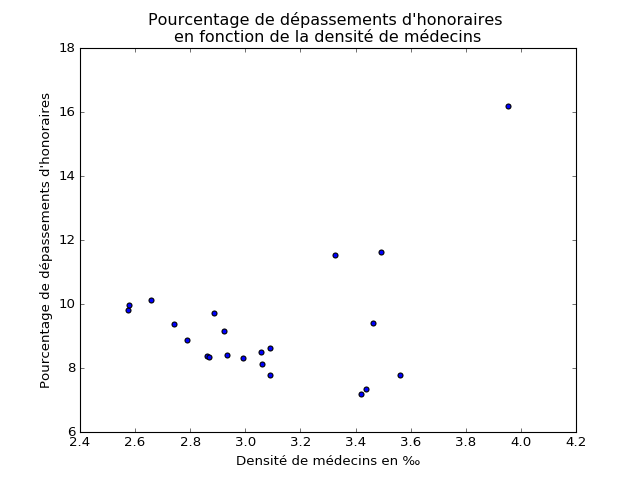

In [36]:
comp.sort_values(by="Ratio(‰)")
# print(comp)

x = comp["Ratio(‰)"].values
y = comp.Ratio_dep.values

plt.figure()
plt.scatter(x, y)
plt.title("Pourcentage de dépassements d'honoraires \nen fonction de la densité de médecins")
plt.xlabel("Densité de médecins en ‰")
plt.ylabel("Pourcentage de dépassements d'honoraires")

In [141]:
# comp.plot.scatter("Ratio(‰)","Ratio_dep")

Au final on ne voit pas particulièrement de corrélation entre densité de l'offre et ratio de dépassements d'honoraires.

Cela est probablement plus lié à la richesse d'une population. Il serait intéresant de croiser ces données avec des données de l'insee sur les revenus par région.

#### Et en regardant par rapport au revenus

In [38]:
revenus = pd.read_csv("~/Hors_icloud/Data/sante/revenus/sante.csv",sep=";")
print(revenus.head(5))

      Region    Revenu
0     Alsace  36 685,5
1  Aquitaine  65 312,7
2   Auvergne  28 057,2
3  Bourgogne  33 176,4
4   Bretagne  64 006,6


In [39]:
revenus.Region = clean_serie(revenus.Region)
revenus.Revenu = revenus.Revenu.str.replace("\xa0","").str.replace("\,",".").astype(float)
print(revenus.head(5))

      Region   Revenu
0     Alsace  36685.5
1  Aquitaine  65312.7
2   Auvergne  28057.2
3  Bourgogne  33176.4
4   Bretagne  64006.6


In [142]:
comp_revenus = pd.merge(comp,revenus,left_index=True,right_on="Region")
print(comp_revenus.head(5))

    Ratio_dep  Ratio(‰)           Region   Revenu
0   11.629951  3.493072           Alsace  36685.5
1    9.415732  3.464023        Aquitaine  65312.7
2    8.137654  3.061527         Auvergne  28057.2
15   8.415307  2.933320  Basse-Normandie  28856.4
3    9.723031  2.886973        Bourgogne  33176.4


<IPython.core.display.Javascript object>


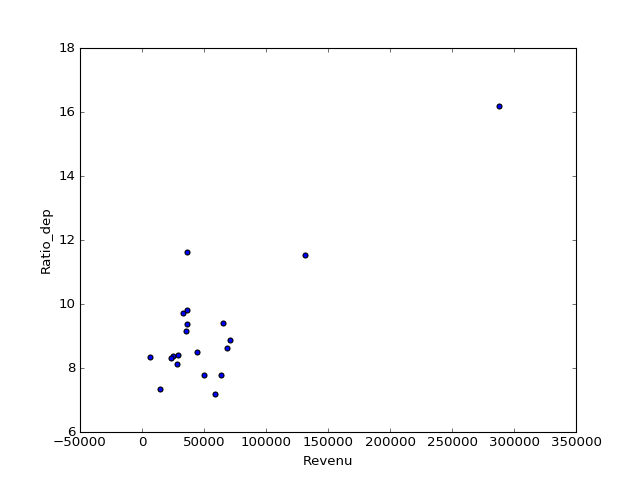

In [41]:
comp_revenus.plot.scatter("Revenu","Ratio_dep")

On obtient une corrélation bien plus marquée entre revenus et pourcentage de dépassements.

# Deuxième sujet: corrélation entre type d'offre de médecins et âge de population.

Est ce que la densité de certains médecins / praticiens est corrélé à la densité de population pour certaines classes d'ages (bebe/pediatre, personnes agées / infirmiers etc...) ?

In [42]:
# long_pop
long_pop.value = long_pop.value.str.replace('\xa0','')
long_pop.value = long_pop.value.astype(int)
#pop_clean = long_pop.set_index("REGION")
#pop_clean.columns = ["age","nombre"]

In [43]:
# repartition_ages = pop_clean
#print(repartition_ages)
long_pop.columns = ["REGION","AGE","NOMBRE"]
long_pop[long_pop.REGION == "France-Métropolitaine"]

,REGION,AGE,NOMBRE
22,France-Métropolitaine,0 à 19 ans,15664305
52,France-Métropolitaine,20 à 39 ans,15480272
82,France-Métropolitaine,40 à 59 ans,17194678
112,France-Métropolitaine,60 à 74 ans,9979654
142,France-Métropolitaine,75 ans et plus,5958333
172,France-Métropolitaine,Total,64277242


In [44]:
# df_detail[df_detail.zone_inscription]

### Comparaison pédiatres et moins de 20 ans, par région

In [45]:
pop_par_tranche = long_pop.pivot("REGION","AGE","NOMBRE")
pop_par_tranche = pop_par_tranche.drop(labels=["France-Métropolitaine","France-Métropolitaine-Et-Dom"])
print(pop_par_tranche.head(5))

AGE              0 à 19 ans  20 à 39 ans  40 à 59 ans  60 à 74 ans  \
REGION                                                               
Alsace               448447       464222       528370       281361   
Aquitaine            755472       757009       920716       577310   
Auvergne             297490       290009       374031       246010   
Basse-Normandie      349147       315085       396745       255831   
Bourgogne            370905       346597       441850       295924   

AGE              75 ans et plus    Total  
REGION                                    
Alsace                   159325  1881725  
Aquitaine                360429  3370936  
Auvergne                 156485  1364025  
Basse-Normandie          162744  1479552  
Bourgogne                186582  1641858  


La population qui nous intéresse est 0-19 ans à comparer avec la proportion de pédiatres, et nombre de pédiatres en valeur absolue.

In [46]:
# uniquement 2014
df_specialites = df_detail[["zone_inscription","specialite","effectifs"]]
df_specialites = df_specialites.set_index("zone_inscription")

# la catégorie à étudier est "Pédiatrie"
# print(df_specialites.specialite.unique())
pediatrie = df_specialites[df_specialites.specialite == "Pédiatrie"].effectifs
print(pediatrie.head(5))

zone_inscription
Alsace             225
Aquitaine          308
Auvergne           110
Basse-Normandie    141
Bourgogne          129
Name: effectifs, dtype: int64


In [47]:
# vérification du pourcentage de jeunes, (voir s'il y a des différences entre régions)
verif_ages = pop_par_tranche[["0 à 19 ans","Total"]]
verif_ages["ratio"] = verif_ages.apply(lambda x: x["0 à 19 ans"]/x["Total"]*100, axis=1)
verif_ages.head()

/Users/leonardbinet/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


AGE,0 à 19 ans,Total,ratio
REGION,,,
Alsace,448447,1881725,23.831697
Aquitaine,755472,3370936,22.411342
Auvergne,297490,1364025,21.809718
Basse-Normandie,349147,1479552,23.598157
Bourgogne,370905,1641858,22.590565


In [48]:
df_comp_ped = pd.concat([pediatrie,verif_ages],axis=1)
df_comp_ped.columns = ["effectifs","nbr_jeunes","pop_totale","pct_jeunes"]
df_comp_ped.head(5)

,effectifs,nbr_jeunes,pop_totale,pct_jeunes
Alsace,225.0,448447.0,1881725.0,23.831697
Aquitaine,308.0,755472.0,3370936.0,22.411342
Auvergne,110.0,297490.0,1364025.0,21.809718
Basse-Normandie,141.0,349147.0,1479552.0,23.598157
Bourgogne,129.0,370905.0,1641858.0,22.590565


<IPython.core.display.Javascript object>


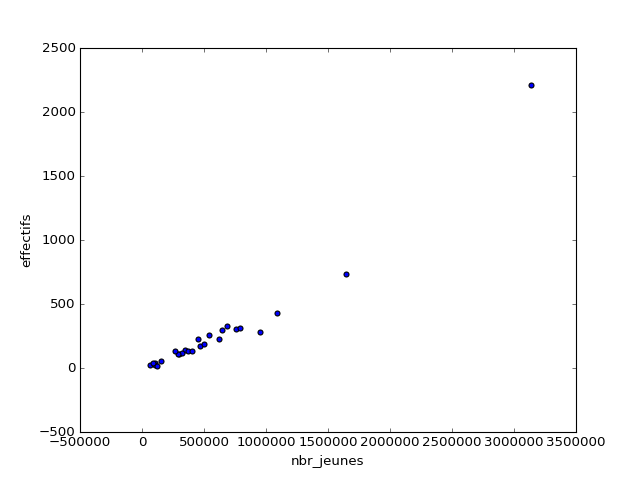

In [49]:
df_comp_ped.plot.scatter("nbr_jeunes","effectifs")

In [104]:
# vérif des vieux
# la catégorie à étudier est "infirmiers"
print(df_specialites.head(5))
#pediatrie = df_specialites[df_specialites.specialite == "Pédiatrie"].effectifs
#print(pediatrie.head(5))

                                           specialite  effectifs
zone_inscription                                                
Alsace            Anatomie et cytologie pathologiques         34
Alsace                         Anesthésie-réanimation        359
Alsace                              Biologie médicale         76
Alsace            Cardiologie et maladies vasculaires        219
Alsace                             Chirurgie générale        120


## Les régions ont elles des répartitions similaires? (sont elles des échantillons indépendants provenant d'une même population, ou sont elles significativement différentes?) 

In [95]:
df_detaille = df_specialites.pivot(index=None,columns="specialite",values="effectifs")
df_detaille.head(5)

specialite,Anatomie et cytologie pathologiques,Anesthésie-réanimation,Biologie médicale,Cardiologie et maladies vasculaires,Chirurgie générale,Chirurgie infantile,Chirurgie maxillo-faciale et stomatologie,Chirurgie orthopédique et traumatologie,Chirurgie plastique reconstructrice et esthétique,Chirurgie thoracique et cardio-vasculaire,...,Ophtalmologie,Pneumologie,Psychiatrie,Pédiatrie,Radio-diagnostic et imagerie médicale,Radio-thérapie,Recherche médicale,Rhumatologie,Réanimation médicale,Santé publique et médecine sociale
zone_inscription,,,,,,,,,,,,,,,,,,,,,
Alsace,34,359,76,219,120,11,15,93,22,18,...,164,85,399,225,275,24,1,62,17,43
Aquitaine,91,613,143,388,167,11,55,172,40,22,...,310,110,840,308,472,43,0,98,7,84
Auvergne,31,220,45,115,77,5,10,61,8,9,...,119,45,246,110,147,20,0,53,5,35
Basse-Normandie,25,208,41,129,85,4,33,57,6,7,...,109,60,226,141,165,21,0,48,3,28
Bourgogne,25,231,53,149,72,5,17,89,14,11,...,108,70,276,129,172,17,0,45,6,38


On va réaliser un test du $\chi^{2}$ en testant l'hypothèse $H_{0}$ = les échantillons proviennent d'une même population. Contre $H_{1} $ = les échantillons proviennent d'une population différente.

Dans le pas de la première hypothèse, $H_{0}$, notre variable aléatoire (effectif par région) suit une loi multinomiale de paramètres $p_{i \in [1,p]}$.

En outre, $d_{0}^{2}=\sum_{i=1}^{k}\sum_{j=1}^{r}\frac {(n_{ij}-n_{i.}p_{j})^{2}} {n_{i}p_{j}}$ suit un $\chi^{2}$ d'ordre $kr-r$.

En revanche, n'ayant pas les valeurs de $p_{i}$ nous allons les approcher par des estimateurs, et :
$$d^{2}=\sum_{i=1}^{k}\sum_{j=1}^{r}\frac { \left(n_{ij}- \frac{n_{i.}n_{j}} {n} \right)^{2}} { \frac{n_{i}n_{.j}}{n}  }$$ est un $ \chi^{2}_{(k-1)(r-1)} $ (avec k le nombre d'échantillons, et r le nombre de modalités.

ie $ P( d^{2} < q_{1-\alpha} )=1-\alpha  $ en notant $ q_{1-\alpha} $ le quantile d'ordre $1-\alpha$ d'un $\chi^{2}_{(k-1)(r-1)}$.

En choisissant un test de risque $\alpha = 5\% $ : on acceptera $H_{0}$ si $d^{2} < q_{0.95}$

Pour éviter des erreurs de calcul, je me suis calqué sur la méthode suivante:
http://hamelg.blogspot.fr/2015/11/python-for-data-analysis-part-25-chi.html

Voir également Saporta Technip page 146, et page 345.

In [109]:
k = len(df_detaille.columns.values)
print("k = %d" %k)
r = len(df_detaille.values)
print("r = %d" %r)
deg_lib = (k-1)*(r-1)
print("Degrés de liberté = %d"%deg_lib)
from scipy import stats
crit = stats.chi2.ppf(q = 0.95, df = deg_lib)
print("Le seuil critique est %.3f"%crit)

k = 41
r = 27
Degrés de liberté = 1040
Le seuil critique est 1116.137


In [81]:
n = df_detaille.sum().sum()
print("n = %d"%n)

# les ni. (nombre de médecins par région)
ni_point = df_detaille.sum(axis=1)
#print(ni_point)
# les n.j (nombre de médecins par spécialité)
n_pointj = df_detaille.sum(axis=0)
# print(n_pointj)

n = 219834


In [105]:
observed = df_detaille

# par spé
col_totals = observed.sum(axis=0)
# par région
row_totals = observed.sum(axis=1)

expected =  np.outer(row_totals.values,
                     col_totals.values / n)

expected = pd.DataFrame(expected)

expected.columns = observed.columns.values
expected.index = observed.index.values

Valeurs attendues en cas d'indépendance:

In [106]:
expected.head(5)

,Anatomie et cytologie pathologiques,Anesthésie-réanimation,Biologie médicale,Cardiologie et maladies vasculaires,Chirurgie générale,Chirurgie infantile,Chirurgie maxillo-faciale et stomatologie,Chirurgie orthopédique et traumatologie,Chirurgie plastique reconstructrice et esthétique,Chirurgie thoracique et cardio-vasculaire,...,Ophtalmologie,Pneumologie,Psychiatrie,Pédiatrie,Radio-diagnostic et imagerie médicale,Radio-thérapie,Recherche médicale,Rhumatologie,Réanimation médicale,Santé publique et médecine sociale
Alsace,46.823139,327.373277,79.593357,203.199269,108.536396,8.581252,35.730301,91.403791,25.773656,12.288832,...,175.063525,86.380619,443.444431,230.527716,253.161890,24.816862,0.418598,77.679767,8.581252,49.813123
Aquitaine,83.181774,581.581889,141.398392,360.985525,192.815988,15.244680,63.475236,162.379746,45.787158,21.831232,...,311.002097,153.456030,787.783450,409.534785,449.744621,44.087402,0.743643,137.998881,15.244680,88.493509
Auvergne,29.747973,207.988864,50.567756,129.097847,68.956030,5.451896,22.700401,58.071236,16.374683,7.807418,...,111.222468,54.879882,281.731925,146.460329,160.840416,15.766806,0.265946,49.352002,5.451896,31.647589
Basse-Normandie,30.916237,216.157009,52.553654,134.167781,71.664074,5.666003,23.591892,60.351811,17.017750,8.114031,...,115.590400,57.035127,292.796110,152.212124,167.156946,16.386000,0.276390,51.290155,5.666003,32.890454
Bourgogne,33.765660,236.079314,57.397309,146.533475,78.269058,6.188215,25.766260,65.914190,18.586206,8.861869,...,126.243893,62.291820,319.781926,166.240891,182.563116,17.896231,0.301864,56.017359,6.188215,35.921832


In [92]:
chi_squared_stat = (((observed-expected)**2)/expected).sum().sum()

print(chi_squared_stat)

4779.715699144


### Contribution au chi deux

Ce tableau permet de détecter quelles sont les classes qui ont le plus joué dans la balance, quelles sont les classes qui font que la différence est très forte entre plusieurs échantillons.

In [120]:
moy_chi = chi_squared_stat/deg_lib
print("La contribution moyenne au chi deux est de : %.3f" %moy_chi)

La contribution moyenne au chi deux est de : 4.596


In [129]:
contrib = (observed - expected)**2/expected
contrib[contrib>10].head(5)

specialite,Anatomie et cytologie pathologiques,Anesthésie-réanimation,Biologie médicale,Cardiologie et maladies vasculaires,Chirurgie générale,Chirurgie infantile,Chirurgie maxillo-faciale et stomatologie,Chirurgie orthopédique et traumatologie,Chirurgie plastique reconstructrice et esthétique,Chirurgie thoracique et cardio-vasculaire,...,Ophtalmologie,Pneumologie,Psychiatrie,Pédiatrie,Radio-diagnostic et imagerie médicale,Radio-thérapie,Recherche médicale,Rhumatologie,Réanimation médicale,Santé publique et médecine sociale
zone_inscription,,,,,,,,,,,,,,,,,,,,,
Alsace,NaN,NaN,NaN,NaN,NaN,NaN,12.027477,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aquitaine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12.305978,NaN,25.173228,NaN,NaN,NaN,11.593648,NaN,NaN
Auvergne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Basse-Normandie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,15.238318,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bourgogne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
#contrib.sum(axis=1)
#contrib.sum(axis=0)

In [110]:
# METHODE DIRECTE
stats.chi2_contingency(observed= observed)

(4779.7156991440006,
 0.0,
 1040,
 array([[   46.82313928,   327.37327711,    79.59335681, ...,
            77.67976746,     8.58125222,    49.81312263],
        [   83.18177352,   581.58188906,   141.39839151, ...,
           137.99888097,    15.24468008,    88.49350874],
        [   29.74797347,   207.98886432,    50.56775567, ...,
            49.35200197,     5.45189552,    31.64758864],
        ..., 
        [   37.48415623,   262.07792243,    63.71827834, ...,
            62.1863588 ,     6.86970168,    39.87778051],
        [  144.15942029,  1007.91921632,   245.05260333, ...,
           239.1610306 ,    26.42002147,   153.36500268],
        [  154.31048882,  1078.89242792,   262.3081234 , ...,
           256.00169219,    28.28040249,   164.1642876 ]]))

Cette valeur 4 fois plus grande que notre seuil critique nous conduit à refuser l'hypothèse que les échantillons sont issus de la même population, avec un risque de 5% de se tromper en rejetant cette hypothèse.

## SUITE : 

In [52]:
pop_tranche_pct = pop_par_tranche.div(pop_par_tranche["Total"],axis="index")*100
#print(pop_par_tranche)
print(pop_tranche_pct.head(5))

AGE              0 à 19 ans  20 à 39 ans  40 à 59 ans  60 à 74 ans  \
REGION                                                               
Alsace            23.831697    24.670024    28.079023    14.952291   
Aquitaine         22.411342    22.456938    27.313363    17.126104   
Auvergne          21.809718    21.261267    27.421125    18.035593   
Basse-Normandie   23.598157    21.295973    26.815212    17.291112   
Bourgogne         22.590565    21.110047    26.911584    18.023727   

AGE              75 ans et plus  Total  
REGION                                  
Alsace                 8.466965  100.0  
Aquitaine             10.692253  100.0  
Auvergne              11.472297  100.0  
Basse-Normandie       10.999546  100.0  
Bourgogne             11.364077  100.0  


In [53]:
df_detaille_complet = pd.concat([df_detaille,pop_tranche_pct.drop('Total',axis=1)],axis=1)
df_detaille_complet

,Anatomie et cytologie pathologiques,Anesthésie-réanimation,Biologie médicale,Cardiologie et maladies vasculaires,Chirurgie générale,Chirurgie infantile,Chirurgie maxillo-faciale et stomatologie,Chirurgie orthopédique et traumatologie,Chirurgie plastique reconstructrice et esthétique,Chirurgie thoracique et cardio-vasculaire,...,Radio-thérapie,Recherche médicale,Rhumatologie,Réanimation médicale,Santé publique et médecine sociale,0 à 19 ans,20 à 39 ans,40 à 59 ans,60 à 74 ans,75 ans et plus
Alsace,34.0,359.0,76.0,219.0,120.0,11.0,15.0,93.0,22.0,18.0,...,24.0,1.0,62.0,17.0,43.0,23.831697,24.670024,28.079023,14.952291,8.466965
Aquitaine,91.0,613.0,143.0,388.0,167.0,11.0,55.0,172.0,40.0,22.0,...,43.0,0.0,98.0,7.0,84.0,22.411342,22.456938,27.313363,17.126104,10.692253
Auvergne,31.0,220.0,45.0,115.0,77.0,5.0,10.0,61.0,8.0,9.0,...,20.0,0.0,53.0,5.0,35.0,21.809718,21.261267,27.421125,18.035593,11.472297
Basse-Normandie,25.0,208.0,41.0,129.0,85.0,4.0,33.0,57.0,6.0,7.0,...,21.0,0.0,48.0,3.0,28.0,23.598157,21.295973,26.815212,17.291112,10.999546
Bourgogne,25.0,231.0,53.0,149.0,72.0,5.0,17.0,89.0,14.0,11.0,...,17.0,0.0,45.0,6.0,38.0,22.590565,21.110047,26.911584,18.023727,11.364077
Bretagne,66.0,500.0,110.0,289.0,126.0,18.0,23.0,139.0,23.0,20.0,...,35.0,0.0,130.0,5.0,69.0,24.039842,22.209895,26.732370,16.548756,10.469137
Centre,47.0,293.0,80.0,220.0,118.0,7.0,33.0,93.0,22.0,7.0,...,36.0,0.0,89.0,9.0,40.0,23.975613,21.762456,26.871398,16.837491,10.553042
Champagne-Ardenne,27.0,169.0,48.0,105.0,81.0,6.0,8.0,61.0,6.0,5.0,...,17.0,0.0,51.0,7.0,24.0,24.128268,23.244388,26.758859,16.300691,9.567794
Corse,3.0,45.0,11.0,36.0,12.0,2.0,8.0,11.0,3.0,0.0,...,4.0,0.0,8.0,0.0,3.0,20.544329,23.594516,27.894022,17.441832,10.525301
Dom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,33.038282,23.902803,26.787616,11.294643,4.976656


In [54]:
df_detaille_complet.columns.values

array(['Anatomie et cytologie pathologiques', 'Anesthésie-réanimation',
       'Biologie médicale', 'Cardiologie et maladies vasculaires',
       'Chirurgie générale', 'Chirurgie infantile',
       'Chirurgie maxillo-faciale et stomatologie',
       'Chirurgie orthopédique et traumatologie',
       'Chirurgie plastique reconstructrice et esthétique',
       'Chirurgie thoracique et cardio-vasculaire', 'Chirurgie urologique',
       'Chirurgie vasculaire', 'Chirurgie viscérale et digestive',
       'Dermatologie et vénéréologie', 'Endocrinologie et métabolisme',
       'Gastro-entérologie et hépatologie', 'Gynécologie médicale',
       'Gynécologie-obstétrique', 'Génétique médicale', 'Gériatrie',
       'Hématologie', 'Médecine du travail', 'Médecine générale',
       'Médecine interne', 'Médecine nucléaire',
       'Médecine physique et réadaptation', 'Neuro-chirurgie',
       'Neurologie', 'Néphrologie', 'O.R.L et chirurgie cervico faciale',
       'Oncologie option médicale', 'Ophtal

## Peut on trouver une prédiction du nombre de spécialistes à partir d'une tranche de population.

In [55]:
from sklearn import linear_model
labels_names = ['Anatomie et cytologie pathologiques', 'Anesthésie-réanimation',
       'Biologie médicale', 'Cardiologie et maladies vasculaires',
       'Chirurgie générale', 'Chirurgie infantile',
       'Chirurgie maxillo-faciale et stomatologie',
       'Chirurgie orthopédique et traumatologie',
       'Chirurgie plastique reconstructrice et esthétique',
       'Chirurgie thoracique et cardio-vasculaire', 'Chirurgie urologique',
       'Chirurgie vasculaire', 'Chirurgie viscérale et digestive',
       'Dermatologie et vénéréologie', 'Endocrinologie et métabolisme',
       'Gastro-entérologie et hépatologie', 'Gynécologie médicale',
       'Gynécologie-obstétrique', 'Génétique médicale', 'Gériatrie',
       'Hématologie', 'Médecine du travail', 'Médecine générale',
       'Médecine interne', 'Médecine nucléaire',
       'Médecine physique et réadaptation', 'Neuro-chirurgie',
       'Neurologie', 'Néphrologie', 'O.R.L et chirurgie cervico faciale',
       'Oncologie option médicale', 'Ophtalmologie', 'Pneumologie',
       'Psychiatrie', 'Pédiatrie', 'Radio-diagnostic et imagerie médicale',
       'Radio-thérapie', 'Recherche médicale', 'Rhumatologie',
       'Réanimation médicale', 'Santé publique et médecine sociale']
print(len(labels_names))
features_names = [ '75 ans et plus'] #'0 à 19 ans','40 à 59 ans', ,'20 à 39 ans',  '60 à 74 ans'' en dehors car sinon matrice dégénérée
X = df_detaille_complet.dropna()[features_names] 
y = df_detaille_complet.dropna()[[1]]
Y = df_detaille_complet.dropna()[labels_names]

from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing

X_scaled = pd.DataFrame(preprocessing.scale(X),index=X.index,columns=X.columns)
Y_scaled = pd.DataFrame(preprocessing.scale(Y),index=Y.index,columns=Y.columns)

multi_model = linear_model.LinearRegression()
multi_regression = MultiOutputRegressor(multi_model).fit(X,Y_scaled)
df_predict = pd.DataFrame(multi_regression.predict(X))
#print(multi_regression.get_params())
#print(df_predict.head(5))
df_predict.index=Y.index
df_predict.columns = labels_names

reussite_regression = ((Y_scaled-df_predict)**2).sum(axis=0)
print(multi_regression.score(X,Y_scaled))
print(reussite_regression.sort_values(ascending=True).head(5))
print(reussite_regression.sort_values(ascending=True).tail(5))

41
0.00278727064593
Recherche médicale                                   25.328628
Chirurgie vasculaire                                 25.593835
Chirurgie viscérale et digestive                     25.831036
Réanimation médicale                                 25.831531
Chirurgie plastique reconstructrice et esthétique    25.840026
dtype: float64
Pneumologie                            25.999319
Gastro-entérologie et hépatologie      25.999764
Neuro-chirurgie                        25.999818
Anatomie et cytologie pathologiques    25.999823
Rhumatologie                           25.999982
dtype: float64


In [56]:
X = df_detaille_complet.dropna()[features_names] 
df_coefs = pd.DataFrame(columns=["Intercept"]+features_names)

for i, label in enumerate(labels_names):
    y = Y_scaled[[i]]
    model = linear_model.LinearRegression(fit_intercept=True)
    model.fit(X_scaled,y)
    df_coef = pd.DataFrame([np.insert(model.coef_,0,model.intercept_)], index=[label], columns=["Intercept"]+features_names)
    df_coefs = df_coefs.append(df_coef)

df_coefs.sort_values(by="75 ans et plus", ascending=False).head(10)
#df_coefs.sort_values(by="0 à 19 ans", ascending=True).head(10)

,Intercept,75 ans et plus
Chirurgie vasculaire,4.683621e-17,0.124987
Chirurgie viscérale et digestive,6.795667e-17,0.080614
Chirurgie urologique,-6.909100e-17,0.076622
Médecine physique et réadaptation,-1.858823e-17,0.069342
Radio-thérapie,-2.864471e-17,0.054391
Médecine générale,2.174606e-17,0.046006
Chirurgie orthopédique et traumatologie,-5.547042e-17,0.042507
Médecine nucléaire,-6.949247e-18,0.015687
Anesthésie-réanimation,-5.882167e-17,0.009462
Médecine du travail,-3.335438e-17,0.007951


# Autre approche, en utilisant le fichier avec libellés

In [57]:
df = pd.read_csv("~/Hors_icloud/Data/R2015/R201501.csv", encoding="iso-8859-1", sep=';')

/Users/leonardbinet/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
df.head(5)

,cpam,l_cpam,dpt,l_dpt,region,l_region,l_serie,SERIE,prs_nat,l_prs_nat,...,l_exe_spe1,exe_stj1,l_exe_stj1,top_slm,l_top_slm,rem_mon,rec_mon,dep_mon,act_dnb,act_coe
0,21,021-Laon,02,02-Aisne,22,22-PICARDIE,C Omnipraticiens,111111,1111,CONSULTATION COTEE C,...,Médecins Omnipraticiens,1,Libéral,1,1-TOP Sections Locales Mutualistes,"-19,80","-66,00","0,00",-3,"-3,00"
1,301,301-Nîmes,30,30-Gard,91,91-LANGUEDOC ROUSSILLON,C Omnipraticiens,111111,1111,CONSULTATION COTEE C,...,Médecins Omnipraticiens,1,Libéral,0,0-TOP Hors Sections Locales Mutualistes,"-26,40","-88,00","0,00",-4,"-4,00"
2,311,311-Toulouse,31,31-Haute-Garonne,73,73-MIDI PYRENEES,C Omnipraticiens,111111,1111,CONSULTATION COTEE C,...,Médecins Omnipraticiens,1,Libéral,1,1-TOP Sections Locales Mutualistes,"13,20","44,00","0,00",2,"2,00"
3,371,371-Tours,37,37-Indre-et-Loire,24,24-CENTRE,C Omnipraticiens,111111,1111,CONSULTATION COTEE C,...,Médecins Omnipraticiens,1,Libéral,0,0-TOP Hors Sections Locales Mutualistes,"6,90","23,00","0,00",1,"1,00"
4,542,542-Nancy,54,54-Meurthe-et-Moselle,41,41-LORRAINE,C Omnipraticiens,111111,1111,CONSULTATION COTEE C,...,Médecins Omnipraticiens,1,Libéral,0,0-TOP Hors Sections Locales Mutualistes,"-125,40","-418,00","0,00",-19,"-19,00"
